In [26]:
import pandas as pd
import numpy as np
import logging
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


Loads dataset from a CSV file.

Applies one-hot encoding to categorical variables (Geography and Stockist_Type).

Ensures these encoded columns exist, raising an error if missing.

Replaces zero sales values to avoid errors in logarithmic computations.

Computes an "Engagement Score", using a log-based formula.

In [27]:
def load_and_preprocess_data(file_path):
    logging.info("Loading dataset...")
    df = pd.read_csv(file_path)

    # One-hot encoding for Geography and Stockist_Type
    df = pd.get_dummies(df, columns=["Geography", "Stockist_Type"], dtype=int)

    # Identify Geography and Stockist_Type columns
    geo_columns = [col for col in df.columns if col.startswith("Geography")]
    stockist_columns = [col for col in df.columns if col.startswith("Stockist_Type")]

    if not geo_columns or not stockist_columns:
        raise ValueError("No Geography or Stockist_Type features found after encoding!")

    # Replace zero sales values to avoid log issues
    df["Sales_Value_Last_Period"] = df["Sales_Value_Last_Period"].replace(0, 1)

    # Compute Engagement Score
    df["Engagement_Score"] = np.log1p(df["Sales_Value_Last_Period"]) * (
        df["Feedback_Score"] + df[stockist_columns+geo_columns].sum(axis=1)
    )

    logging.info("Data preprocessing completed.")
    return df, geo_columns, stockist_columns


Splits the dataset into 80% training and 20% testing.

Uses stratified sampling based on Partner_id to maintain distribution.

In [28]:
def prepare_train_test_data(df):
    logging.info("Splitting data into train and test sets...")
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Partner_id"])
    logging.info("Train-test split completed.")
    return train_df, test_df


Creates a pivot table where Partner_id is the index, Scheme_Type is columns, and Engagement_Score is aggregated.

Merges geographical and stockist-type features with the user-scheme matrix.

In [29]:
def create_user_scheme_matrix(train_data, geo_columns, stockist_columns):
    user_scheme_matrix = train_data.pivot_table(
        index="Partner_id", columns="Scheme_Type", values="Engagement_Score", aggfunc="sum", fill_value=0
    )
    user_features = train_data.groupby("Partner_id")[geo_columns + stockist_columns].mean()
    user_scheme_matrix = user_scheme_matrix.merge(user_features, left_index=True, right_index=True, how="left")

    logging.info("User-scheme matrix created.")
    return user_scheme_matrix


Converts the user-scheme matrix into a sparse matrix.

Trains a K-Nearest Neighbors (KNN) model using cosine similarity.

In [30]:
def train_knn_model(user_scheme_matrix):
    sparse_matrix = csr_matrix(user_scheme_matrix.values)
    partner_id_lookup = list(user_scheme_matrix.index)

    knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
    knn_model.fit(sparse_matrix)

    logging.info("KNN model trained successfully.")
    return knn_model, sparse_matrix, partner_id_lookup


Finds nearest neighbors for a given partner_id.

Returns top-3 recommended schemes for a similar user.

In [31]:
def recommend_user_based(partner_id, user_scheme_matrix, sparse_matrix, partner_id_lookup, knn_model, train_df, top_n=3):
    """Recommend schemes based on similar users."""
    if partner_id not in user_scheme_matrix.index:
        return None

    idx = partner_id_lookup.index(partner_id)
    distances, indices = knn_model.kneighbors(sparse_matrix[idx], n_neighbors=min(top_n + 1, len(user_scheme_matrix)))
    similarities = 1 - distances.flatten()
    neighbors = indices.flatten()

    filtered = [(i, sim) for i, sim in zip(neighbors, similarities) if i != idx]
    if not filtered:
        return None

    top_idx, sim_score = filtered[0]
    similar_user = partner_id_lookup[top_idx]
    sim_score = round(sim_score, 6)

    top_schemes = (
        train_df[train_df["Partner_id"] == similar_user]["Scheme_Type"]
        .value_counts().head(3).index.tolist()
    )
    while len(top_schemes) < 3:
        top_schemes.append("No Scheme")

    product = train_df[train_df["Partner_id"] == partner_id]["Product_id"].unique()[0]

    return [partner_id, product, sim_score, *top_schemes]

Iterates through test dataset users and generates recommendations.



In [32]:
def generate_recommendations(knn_model, user_scheme_matrix, sparse_matrix, partner_id_lookup, train_df, test_df):
    """Generate recommendations for all test users."""
    logging.info("Generating recommendations...")
    user_partners = test_df["Partner_id"].unique()

    recommendations = [
        recommend_user_based(pid, user_scheme_matrix, sparse_matrix, partner_id_lookup, knn_model, train_df) 
        for pid in user_partners if recommend_user_based(pid, user_scheme_matrix, sparse_matrix, partner_id_lookup, knn_model, train_df)
    ]

    logging.info("Recommendations generated successfully.")
    return recommendations


logging.basicConfig(level=logging.INFO)

Uses Permutation Feature Importance (PFI) to evaluate how much each feature impacts recommendations.

In [39]:
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

def compute_feature_importance(df, feature_columns, train_df, test_df, geo_columns, stockist_columns, knn_model, user_scheme_matrix, user_scheme_sparse, partner_id_lookup, num_shuffles=50):
    """Computes Permutation Feature Importance (PFI) for the recommendation system over multiple shuffles."""
    importance_scores = {feature: [] for feature in feature_columns}

    # Generate Baseline Recommendations
    baseline_recommendations = {
        pid: recommend_user_based(pid, user_scheme_matrix, user_scheme_sparse, partner_id_lookup, knn_model, train_df) 
        for pid in test_df["Partner_id"].unique()
    }

    # Convert to DataFrame
    baseline_df = pd.DataFrame(
        [v for v in baseline_recommendations.values() if v],
        columns=["Partner_id", "Product_id", "Similarity_Score", "Scheme_1", "Scheme_2", "Scheme_3"]
    ).set_index(["Partner_id", "Product_id"])

    for feature in feature_columns:
        for _ in range(num_shuffles):
            perturbed_df = deepcopy(df)
            
            # Shuffle ONLY the selected feature column
            perturbed_df[feature] = np.random.permutation(perturbed_df[feature].values)

            # Train-Test Split Again
            train_df_perturbed = perturbed_df.loc[train_df.index]

            # Recompute Engagement Score
            train_df_perturbed["Engagement_Score"] = np.log1p(train_df_perturbed["Sales_Value_Last_Period"]) * (
                train_df_perturbed["Feedback_Score"] + train_df_perturbed[geo_columns + stockist_columns].sum(axis=1)
            )

            # Pivot User-Scheme Matrix
            user_scheme_matrix_perturbed = train_df_perturbed.pivot_table(
                index="Partner_id", columns="Scheme_Type", values="Engagement_Score", aggfunc="sum", fill_value=0
            )

            # Add Geography & Stockist_Type Features
            user_features_perturbed = train_df_perturbed.groupby("Partner_id")[geo_columns + stockist_columns].sum()
            user_scheme_matrix_perturbed = user_scheme_matrix_perturbed.merge(
                user_features_perturbed, left_index=True, right_index=True, how="left"
            )

            # Prepare sparse matrix and retrain KNN
            user_scheme_sparse_perturbed = csr_matrix(user_scheme_matrix_perturbed.values)
            knn_model.fit(user_scheme_sparse_perturbed)

            # Generate New Recommendations
            perturbed_recommendations = {
                pid: recommend_user_based(pid, user_scheme_matrix_perturbed, user_scheme_sparse_perturbed, partner_id_lookup, knn_model, train_df_perturbed) 
                for pid in test_df["Partner_id"].unique()
            }

            # Check for empty recommendations
            if perturbed_recommendations:
                perturbed_recommendations_df = pd.DataFrame(
                    [v for v in perturbed_recommendations.values() if v],
                    columns=["Partner_id", "Product_id", "Similarity_Score", "Scheme_1", "Scheme_2", "Scheme_3"]
                ).set_index(["Partner_id", "Product_id"])
            else:
                perturbed_recommendations_df = baseline_df.copy()  # Avoid errors if empty

            # Compare Recommendations
            scheme_columns = ["Scheme_1", "Scheme_2", "Scheme_3"]
            changed_recommendations = (baseline_df[scheme_columns] != perturbed_recommendations_df[scheme_columns]).any(axis=1)
            changed_count = changed_recommendations.sum()

            # Normalize by total recommendations in baseline
            importance_scores[feature].append(changed_count / len(baseline_df))

    # Compute average importance score over multiple shuffles
    importance_scores = {feature: np.mean(scores) for feature, scores in importance_scores.items()}

    return importance_scores


In [40]:
if __name__ == "__main__":
     base_dir = os.getcwd()
     file_path = os.path.join(base_dir, "Augmented_Stockist_Data (1).csv")

    # Load and preprocess data
    df, geo_columns, stockist_columns = load_and_preprocess_data(file_path)

    # Shuffle dataset and track iterations
    #df = shuffle_and_track_iterations(df, num_shuffles=5)

    # Split data
    train_df, test_df = prepare_train_test_data(df)

    # Create User-Scheme Matrix
    user_scheme_matrix = create_user_scheme_matrix(train_df, geo_columns, stockist_columns)

    # Train KNN Model
    knn_model, sparse_matrix, partner_id_lookup = train_knn_model(user_scheme_matrix)

    # Generate Recommendations
    recommendations = generate_recommendations(knn_model, user_scheme_matrix, sparse_matrix, partner_id_lookup, train_df, test_df)

    # Save Recommendations
    user_rec_df = pd.DataFrame(recommendations, columns=["Partner_id", "Product_id", "Similarity_Score", "Scheme_1", "Scheme_2", "Scheme_3"])
    user_rec_df.to_csv("user_based_recommendations_with_geography_stockist.csv", index=False)
    logging.info("User-Based Recommendations saved successfully.")

    # Compute Feature Importance using PFI
    geo_importance = compute_feature_importance(df, geo_columns, train_df, test_df, geo_columns, stockist_columns, knn_model, user_scheme_matrix, sparse_matrix, partner_id_lookup)
    stockist_importance = compute_feature_importance(df, stockist_columns, train_df, test_df, geo_columns, stockist_columns, knn_model, user_scheme_matrix, sparse_matrix, partner_id_lookup)

    # Print Results
    print("\nFeature Importance (Higher means more impact on recommendations):")
    print("Geography Feature Importance:")
    print(pd.Series(geo_importance).sort_values(ascending=False))

    print("\nStockist_Type Feature Importance:")
    print(pd.Series(stockist_importance).sort_values(ascending=False))


2025-04-04 11:02:47,689 - INFO - Loading dataset...
2025-04-04 11:02:47,752 - INFO - Data preprocessing completed.
2025-04-04 11:02:47,752 - INFO - Splitting data into train and test sets...
2025-04-04 11:02:47,787 - INFO - Train-test split completed.
2025-04-04 11:02:47,804 - INFO - User-scheme matrix created.
2025-04-04 11:02:47,804 - INFO - KNN model trained successfully.
2025-04-04 11:02:47,804 - INFO - Generating recommendations...
2025-04-04 11:02:49,015 - INFO - Recommendations generated successfully.
2025-04-04 11:02:49,020 - INFO - User-Based Recommendations saved successfully.



Feature Importance (Higher means more impact on recommendations):
Geography Feature Importance:
Geography_South    0.348119
Geography_East     0.340594
Geography_North    0.325941
Geography_West     0.318416
dtype: float64

Stockist_Type Feature Importance:
Stockist_Type_Wholesaler     0.441584
Stockist_Type_Distributor    0.430099
Stockist_Type_Retailer       0.388515
dtype: float64


In [41]:
# Convert to DataFrame for saving to CSV
geo_importance_df_50 = pd.DataFrame(list(geo_importance.items()), columns=["Feature", "Importance"])
stockist_importance_df_50 = pd.DataFrame(list(stockist_importance.items()), columns=["Feature", "Importance"])

# Save results to CSV files
geo_importance_df_50.to_csv("geo_feature_importance_50.csv", index=False)
stockist_importance_df_50.to_csv("stockist_feature_importance_50.csv", index=False)


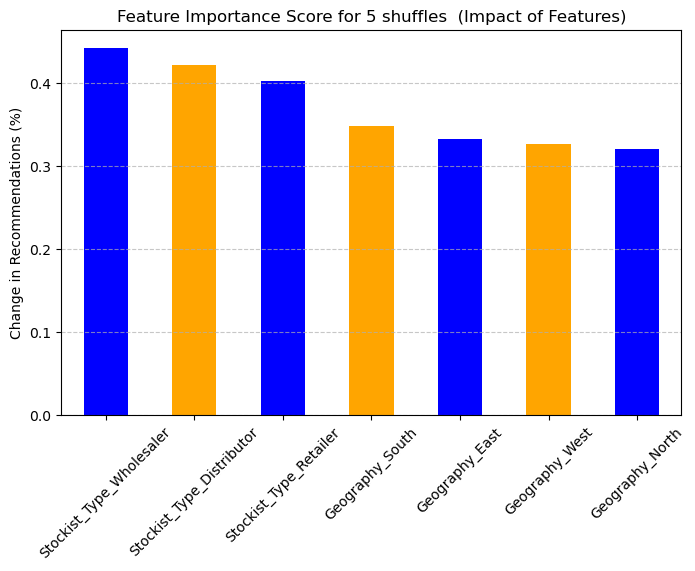

In [38]:
import matplotlib.pyplot as plt

importance_scores = {**geo_importance, **stockist_importance}

# Convert to Pandas Series for plotting
importance_series = pd.Series(importance_scores)

# Plot feature importance as a bar graph
plt.figure(figsize=(8, 5))
importance_series.sort_values(ascending=False).plot(kind='bar', color=['blue', 'orange'])
plt.title("Feature Importance Score for 5 shuffles  (Impact of Features)")
plt.ylabel("Change in Recommendations (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

In [45]:
# 5 shuffle
geo_importance_df_5

,Feature,Importance
0,Geography_East,0.332673
1,Geography_North,0.320792
2,Geography_South,0.348515
3,Geography_West,0.326733


In [46]:
# 5 shuffle
stockist_importance_df_5

,Feature,Importance
0,Stockist_Type_Distributor,0.421782
1,Stockist_Type_Retailer,0.401980
2,Stockist_Type_Wholesaler,0.441584


In [42]:
# 50 shuffles
geo_importance_df_50

,Feature,Importance
0,Geography_East,0.340594
1,Geography_North,0.325941
2,Geography_South,0.348119
3,Geography_West,0.318416


In [43]:
stockist_importance_df_50

,Feature,Importance
0,Stockist_Type_Distributor,0.430099
1,Stockist_Type_Retailer,0.388515
2,Stockist_Type_Wholesaler,0.441584


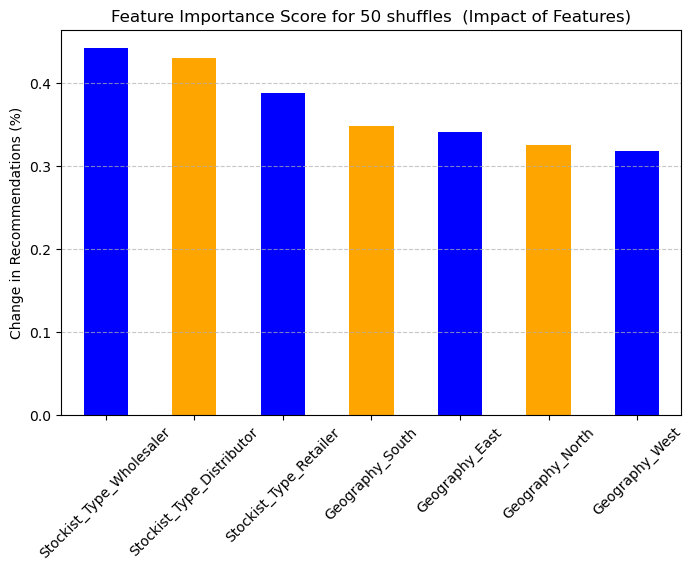

In [44]:
import matplotlib.pyplot as plt

importance_scores = {**geo_importance, **stockist_importance}

# Convert to Pandas Series for plotting
importance_series = pd.Series(importance_scores)

# Plot feature importance as a bar graph
plt.figure(figsize=(8, 5))
importance_series.sort_values(ascending=False).plot(kind='bar', color=['blue', 'orange'])
plt.title("Feature Importance Score for 50 shuffles  (Impact of Features)")
plt.ylabel("Change in Recommendations (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()